In [126]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()
sns.set()

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [111]:
train_df = pd.read_csv("data/train.csv")

macro_df = pd.read_csv("data/macro.csv")
macro_df['date'] = pd.to_datetime(macro_df['timestamp'])

# Target value

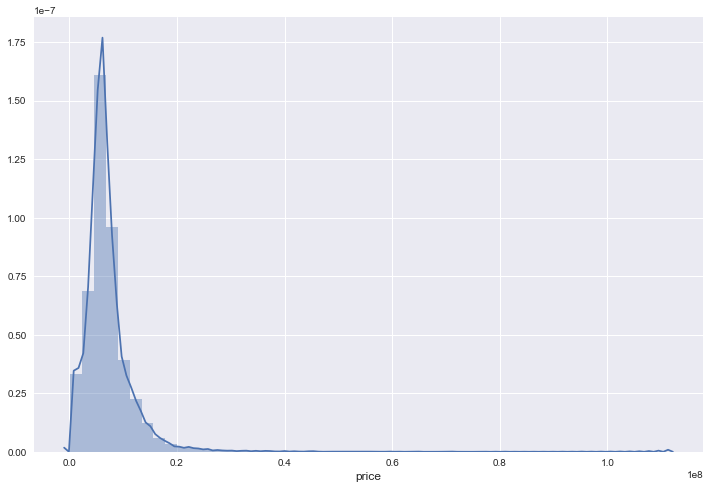

In [94]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

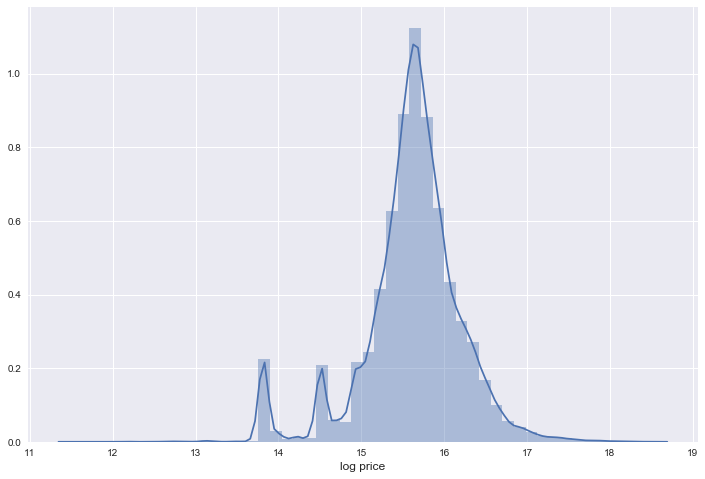

In [95]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('log price', fontsize=12)
plt.show()

# MACRO

In [223]:
MACRO_COLUMNS = []

In [103]:
macro_df.dtypes[(macro_df.dtypes!="float64") & (macro_df.dtypes!="int64")]

timestamp                            object
child_on_acc_pre_school              object
modern_education_share               object
old_education_build_share            object
date                         datetime64[ns]
dtype: object

In [112]:
def _replace_incorrect_str(x):
    if x=="#!":
        return np.nan
    return x.replace(",", ".") if pd.notnull(x) else x

macro_df.child_on_acc_pre_school = macro_df.child_on_acc_pre_school.apply(_replace_incorrect_str).astype(float)
macro_df.modern_education_share = macro_df.modern_education_share.apply(_replace_incorrect_str).astype(float)
macro_df.old_education_build_share = macro_df.old_education_build_share.apply(_replace_incorrect_str).astype(float)

#########################
rent_price_1room_bus     0.890097
rent_price_2room_bus     0.890097
rent_price_3room_bus     0.890097
rent_price_4+room_bus    0.890097
dtype: float64


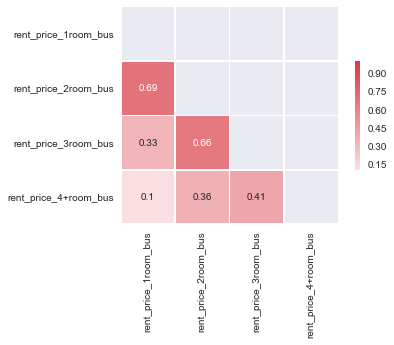

In [247]:
def get_corr_empty_info(df, cols):
    def _calc_empty(x):
        return len(x.dropna())/len(x)
    
    cdf = df[sorted(cols)].sort_index()
    corr_df = cdf.corr()
    empty_info = cdf[sorted(cols)].apply(_calc_empty, axis=0)
    
    mask = np.zeros_like(corr_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(6, 4))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_df, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    
    print("#########################")
    print(empty_info)
    
    return corr_df, empty_info

# cols = ["gdp_annual", "gdp_annual_growth", "gdp_deflator", "gdp_quart", "gdp_quart_growth", "grp", "grp_growth"]
# cols = ["gdp_annual_growth", "gdp_quart_growth", "cpi"]

cols = ["rent_price_1room_bus", "rent_price_2room_bus" , "rent_price_3room_bus", "rent_price_4+room_bus"]#, 
#         "rent_price_1room_eco", "rent_price_2room_eco", "rent_price_3room_eco"]
corr_df, empty_info = get_corr_empty_info(macro_df, cols)

MACRO_COLUMNS.append(["gdp_annual_growth", "gdp_quart_growth"])

In [217]:
# gdp_annual
# gdp_annual_growth
# gdp_deflator
# gdp_quart
# gdp_quart_growth

# grp
# grp_growth

# cpi
# ppi

# oil_urals
# usdrub
# eurrub

# micex
# micex_cbi_tr
# micex_rgbi_tr

# rent_price_1room_bus
# rent_price_1room_eco
# rent_price_2room_bus
# rent_price_2room_eco
# rent_price_3room_bus
# rent_price_3room_eco
# rent_price_4+room_bus

# apartment_build
# apartment_fund_sqm
# average_life_exp
# average_provision_of_build_contract
# average_provision_of_build_contract_moscow
# balance_trade
# balance_trade_growth
# bandwidth_sports
# baths_share
# brent
# child_on_acc_pre_school
# childbirth
# construction_value
# date
# deposits_growth
# deposits_rate
# deposits_value
# divorce_rate
# electric_stove_share
# employment
# fin_res_per_cap
# fixed_basket
# gas_share
# heating_share
# hospital_bed_occupancy_per_year
# hospital_beds_available_per_cap
# hot_water_share
# housing_fund_sqm
# incidence_population
# income_per_cap
# infant_mortarity_per_1000_cap
# invest_fixed_assets
# invest_fixed_assets_phys
# invest_fixed_capital_per_cap
# labor_force
# load_of_teachers_preschool_per_teacher
# load_of_teachers_school_per_teacher
# load_on_doctors
# lodging_sqm_per_cap
# marriages_per_1000_cap
# modern_education_share
# mortality
# mortgage_growth
# mortgage_rate
# mortgage_value
# museum_visitis_per_100_cap
# net_capital_export
# old_education_build_share
# old_house_share
# overdue_wages_per_cap
# perinatal_mort_per_1000_cap
# pop_migration
# pop_natural_increase
# pop_total_inc
# population_reg_sports_share
# power_clinics
# profitable_enterpr_share
# provision_doctors
# provision_nurse
# provision_retail_space_modern_sqm
# provision_retail_space_sqm
# real_dispos_income_per_cap_growth

# retail_trade_turnover
# retail_trade_turnover_growth
# retail_trade_turnover_per_cap
# rts
# salary
# salary_growth
# seats_theather_rfmin_per_100000_cap
# sewerage_share
# share_own_revenues
# students_reg_sports_share
# students_state_oneshift
# theaters_viewers_per_1000_cap
# timestamp
# turnover_catering_per_cap
# unemployment
# unprofitable_enterpr_share
# water_pipes_share

In [213]:
corr_macro = macro_df.corr()
corr_macro_sorted = corr_macro[sorted(corr_macro.columns)].sort_index()

corr_macro_unstack = corr_macro_sorted.unstack().reset_index()
corr_macro_unstack.columns = ["columns_names", "index_names", "corrcoef"]
low_corr_df = corr_macro_unstack[abs(corr_macro_unstack.corrcoef.abs())<=0.2].copy()

4       average_provision_of_build_contract_moscow
14                                 deposits_growth
50                                   micex_rgbi_tr
65                                   pop_total_inc
81                           rent_price_4+room_bus
101                               average_life_exp
102            average_provision_of_build_contract
107                                    baths_share
118                                     employment
123                                     gdp_annual
126                                      gdp_quart
129                                     grp_growth
130                                  heating_share
136                                 income_per_cap
137                  infant_mortarity_per_1000_cap
138                            invest_fixed_assets
140                   invest_fixed_capital_per_cap
141                                    labor_force
145                            lodging_sqm_per_cap
146                         mar

In [177]:
corr_macro_trace = go.Heatmap(z=corr_macro_sorted.values.tolist(),
                   x=corr_macro_sorted.columns.tolist(),
                   y=corr_macro_sorted.index.tolist())
corr_macro_layout = go.Layout(
#     autosize=False,
#     width=800,
#     height=600,
    margin=go.Margin(
        l=250,
        r=100,
        b=200,
        t=50,
        pad=5
    ),
    xaxis=dict(tickangle=325),
    yaxis=dict(tickangle=0)
)
corr_macro_fig = go.Figure(data=[corr_macro_trace], layout=corr_macro_layout)
iplot(corr_macro_fig, filename='macro_corr')

In [23]:
# first let's average per day
gb_train = train_df.groupby(['timestamp'])
dfagg = pd.DataFrame()
dfagg['avg_price_per_sqm'] = gb_train.price_doc.sum() / gb_train.full_sq.sum()
dfagg['rolling_average_immo'] = dfagg['avg_price_per_sqm'].rolling(30).mean()
dfagg.reset_index(inplace=True)
dfagg = pd.merge(dfagg, macro_df, how='left', on=['timestamp'])

In [35]:
macro_df.columns

Index(['timestamp', 'oil_urals', 'gdp_quart', 'gdp_quart_growth', 'cpi', 'ppi',
       'gdp_deflator', 'balance_trade', 'balance_trade_growth', 'usdrub',
       ...
       'turnover_catering_per_cap', 'theaters_viewers_per_1000_cap',
       'seats_theather_rfmin_per_100000_cap', 'museum_visitis_per_100_cap',
       'bandwidth_sports', 'population_reg_sports_share',
       'students_reg_sports_share', 'apartment_build', 'apartment_fund_sqm',
       'date'],
      dtype='object', length=101)